# Character Based LSTM
### w266 Fall - Simon Storey 

This notebook contains character based network that uses character embeddings, convolutional layers, highway network and an LSTM built using Tensorflow that mimics the work done in the research paper 'Character-Level LSTM Implementation Based on Character-Aware Neural Language Models' (arXiv:1508.06615v4) created by Yoon Kim, Yacine Jernite, David Sontag and Alexander Rush.

The paper performed its analysis on the Penn TreeBank and their implementation can be found here https://github.com/yoonkim/lstm-char-cnn and is built using PyTorch.

Our analysis has been converted to leverage the Sentiment140 dataset provided by the Stanford NLP team (http://help.sentiment140.com/for-students/).

Experimentation results from hyperparameter tuning and adhoc experimentation have been stored on a server hosted on GCP using the open source toolkit - Databricks MLFlow.

References:
- Time Delay Neural Network ( cf. http://www.aclweb.org/anthology/P/P14/P14-1062.xhtml )
- Highway Network ( cf. http://arxiv.org/abs/1505.00387 )
- Character-Aware Neural Language Models (cf. https://arxiv.org/pdf/1508.06615.pdf )
- Blog posting by Charles Ashby (cf. https://charlesashby.github.io/ )

Note: run this command to allow jupyter to use the custom conda environment

```shell
ipython kernel install --user --name=char_lstm
```

Please see the provided requirements.txt, this includes all libraries needed to run this code in python3.6 using conda

Data utils contains all the file handling and conversion of sentiment train/test files from Latin1 to utf8. 
Final files used for TRAIN/DEV/TEST normalized to match those used by other team members that included cleaning, stemming and other optimizations ( discussed in our paper ). 

In [37]:
import data_utils as d
import sys
stdout = sys.stdout

TRAIN_SET = TextReader.TRAIN_SET
TEST_SET = TextReader.TEST_SET
DEV_SET = TextReader.DEV_SET
QA_SET = TextReader.QA_SET # Subset of dev_set limited to 100 rows for quick tests

SAVE_PATH = PATH + 'checkpoints/lstm'
LOGGING_PATH = PATH + 'checkpoints/log.txt'

reload(d)
print(TRAIN_SET)
print(TEST_SET)
print(DEV_SET)
print(QA_SET)

d.TextReader.get_number_of_samples(QA_SET)

./../../data/fully_cleansed_train_data.csv
./../../data/fully_cleansed_test_data.csv
./../../data/fully_cleansed_dev_data.csv
./../../data/fully_cleansed_qa_data.csv


10000

In [2]:
!rmdir 'checkpoints/lstm'

rmdir: failed to remove 'checkpoints/lstm': No such file or directory


In [3]:
!nvidia-smi

Fri Dec  7 02:11:56 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
with tf.Session() as sess:
      print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 14273104558271766830), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17036162173481110769), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6001888963057595848), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 15864515789, 6477141511754743324)]


In [7]:
print(tf.test.is_built_with_cuda())

True


In [3]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(hello))

b'Hello, TensorFlow!'


In [4]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


TEST mini-batching using DEV set using the TextReader from the data_utils library

In [8]:
max_word_length = 1

with open(d.TextReader.DEV_SET, 'r',encoding='utf8') as f:
    reader = d.TextReader(f, max_word_length)
    n_samples = 2
    batch_size = 1
    n_batch = int(n_samples // batch_size)
    
    for i in range(n_batch):
        if reader.load_to_ram(batch_size):                
            a,b = reader.make_minibatch(reader.data)
            print(a)
            print(b)

[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
    0. 0. 0. 0.]]]]
[[1 0]]
[[[[1. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]]]]
[[0 1]]


Check various functions for data prep

In [9]:
t = d.TextReader(None,50)
sentence = 'Hi there'
print('encode sentence: ',t.encode_sentence(sentence))
print('one hot: ',t.encode_one_hot(sentence))

encode sentence:  hi there
one hot:  (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), 2)


Test mini_batch

In [10]:
sentences = ['Hi there ,1 ','How are you doing today ,1 ','"How is the weather in Boston?", 0']
print('mini_batch: ', t.make_minibatch(sentences))

mini_batch:  (array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

Check file to ensure formatted correctly and count lines

In [11]:
with open(QA_SET, 'r', encoding = "utf8") as f:
    t=d.TextReader(f,5)
    t.check_file(d.TextReader.QA_SET, True)

eof line count @ 20


Lets check and iterate over a minibatch ( running one-hot encoding ) 

In [38]:
with open(QA_SET, 'r', encoding = "utf8") as f:
    t=d.TextReader(f,16,True)
    for n, x in enumerate(t.iterate_minibatch(1, d.TextReader.QA_SET)):
        print('batch: ',n)
        print('-----------------------------------------------------')

Original:  sure thing should start with ustream amp blip channel or go big right out of gate buy brick amp mortar twittv,4 
Sentiment:  4 
Sentence:  sure thing should start with ustream amp blip channel or go big right out of gate buy brick amp mortar twittv
one_hot shape: (21, 16, 70)
batch:  0
-----------------------------------------------------
Original:  thank for video for alo girl tonight enjoy veri much,4 
Sentiment:  4 
Sentence:  thank for video for alo girl tonight enjoy veri much
one_hot shape: (10, 16, 70)
batch:  1
-----------------------------------------------------
Original:  so sad didnt camera while burn,0 
Sentiment:  0 
Sentence:  so sad didnt camera while burn
one_hot shape: (6, 16, 70)
batch:  2
-----------------------------------------------------
Original:  not nice night to out on tile drive safe,0 
Sentiment:  0 
Sentence:  not nice night to out on tile drive safe
one_hot shape: (9, 16, 70)
batch:  3
-----------------------------------------------------
Orig

Original:  day number man im so stupid serious fuck up,0 
Sentiment:  0 
Sentence:  day number man im so stupid serious fuck up
one_hot shape: (9, 16, 70)
batch:  140
-----------------------------------------------------
Original:  wait with for im down $65,0 
Sentiment:  0 
Sentence:  wait with for im down $65
one_hot shape: (7, 16, 70)
batch:  141
-----------------------------------------------------
Original:  what up,0 
Sentiment:  0 
Sentence:  what up
one_hot shape: (2, 16, 70)
batch:  142
-----------------------------------------------------
Original:  see of purpl white love httptwitpiccom7i76g,4 
Sentiment:  4 
Sentence:  see of purpl white love httptwitpiccom7i76g
one_hot shape: (6, 16, 70)
batch:  143
-----------------------------------------------------
Original:  lol no im not ive to studi hard =d talk to later nice week end bye,4 
Sentiment:  4 
Sentence:  lol no im not ive to studi hard =d talk to later nice week end bye
one_hot shape: (16, 16, 70)
batch:  144
----------

-----------------------------------------------------
Original:  as lanki as ami not suit skinni leg jean evid love of macca fri goe straight to thigh,0 
Sentiment:  0 
Sentence:  as lanki as ami not suit skinni leg jean evid love of macca fri goe straight to thigh
one_hot shape: (18, 16, 70)
batch:  272
-----------------------------------------------------
Original:  go to work,0 
Sentiment:  0 
Sentence:  go to work
one_hot shape: (3, 16, 70)
batch:  273
-----------------------------------------------------
Original:  disappoint mode on thought mv out today,0 
Sentiment:  0 
Sentence:  disappoint mode on thought mv out today
one_hot shape: (7, 16, 70)
batch:  274
-----------------------------------------------------
Original:  headachegoin to bed,0 
Sentiment:  0 
Sentence:  headachegoin to bed
one_hot shape: (3, 16, 70)
batch:  275
-----------------------------------------------------
Original:  wasnt kid,0 
Sentiment:  0 
Sentence:  wasnt kid
one_hot shape: (2, 16, 70)
batch:  276


one_hot shape: (14, 16, 70)
batch:  409
-----------------------------------------------------
Original:  just hung out with great grandma might hang out with twice week now,4 
Sentiment:  4 
Sentence:  just hung out with great grandma might hang out with twice week now
one_hot shape: (13, 16, 70)
batch:  410
-----------------------------------------------------
Original:  pleas come,0 
Sentiment:  0 
Sentence:  pleas come
one_hot shape: (2, 16, 70)
batch:  411
-----------------------------------------------------
Original:  awww haha ur ador xd naw dutch good but eh want to studi here awesom want to studi when,4 
Sentiment:  4 
Sentence:  awww haha ur ador xd naw dutch good but eh want to studi here awesom want to studi when
one_hot shape: (19, 16, 70)
batch:  412
-----------------------------------------------------
Original:  love cancuk lt3,4 
Sentiment:  4 
Sentence:  love cancuk lt3
one_hot shape: (3, 16, 70)
batch:  413
-----------------------------------------------------
Origin

Original:  ivana so cute httpbitlymrybp,4 
Sentiment:  4 
Sentence:  ivana so cute httpbitlymrybp
one_hot shape: (4, 16, 70)
batch:  531
-----------------------------------------------------
Original:  replac coffe with chocol milk no wonder morn headach still on,0 
Sentiment:  0 
Sentence:  replac coffe with chocol milk no wonder morn headach still on
one_hot shape: (11, 16, 70)
batch:  532
-----------------------------------------------------
Original:  go to mom today spend time with dita take cha to work until ugh anyway,0 
Sentiment:  0 
Sentence:  go to mom today spend time with dita take cha to work until ugh anyway
one_hot shape: (15, 16, 70)
batch:  533
-----------------------------------------------------
Original:  go to london from th to th of august yippieyippieyeah,4 
Sentiment:  4 
Sentence:  go to london from th to th of august yippieyippieyeah
one_hot shape: (10, 16, 70)
batch:  534
-----------------------------------------------------
Original:  im soooooo sun burnt s

-----------------------------------------------------
Original:  thursday night market creep over horizon six oclock haha,4 
Sentiment:  4 
Sentence:  thursday night market creep over horizon six oclock haha
one_hot shape: (9, 16, 70)
batch:  644
-----------------------------------------------------
Original:  nervou about dentist at in morningwish luck,0 
Sentiment:  0 
Sentence:  nervou about dentist at in morningwish luck
one_hot shape: (7, 16, 70)
batch:  645
-----------------------------------------------------
Original:  thank tay yeah at tpp yesterday sat in on session littl girl not fun tho,4 
Sentiment:  4 
Sentence:  thank tay yeah at tpp yesterday sat in on session littl girl not fun tho
one_hot shape: (15, 16, 70)
batch:  646
-----------------------------------------------------
Original:  hah just realiz kyle not chri gotta love avatar name,4 
Sentiment:  4 
Sentence:  hah just realiz kyle not chri gotta love avatar name
one_hot shape: (11, 16, 70)
batch:  647
------------

batch:  782
-----------------------------------------------------
Original:  ãâaww im skip back home almost got lost on last block dx,0 
Sentiment:  0 
Sentence:  ãâaww im skip back home almost got lost on last block dx
one_hot shape: (12, 16, 70)
batch:  783
-----------------------------------------------------
Original:  watch iron chef zucchini haha show crack up,4 
Sentiment:  4 
Sentence:  watch iron chef zucchini haha show crack up
one_hot shape: (8, 16, 70)
batch:  784
-----------------------------------------------------
Original:  wish stupid headach would go away alreadi,0 
Sentiment:  0 
Sentence:  wish stupid headach would go away alreadi
one_hot shape: (7, 16, 70)
batch:  785
-----------------------------------------------------
Original:  cliiii hope surgeri goe well bb,0 
Sentiment:  0 
Sentence:  cliiii hope surgeri goe well bb
one_hot shape: (6, 16, 70)
batch:  786
-----------------------------------------------------
Original:  thank for explain understand player po

one_hot shape: (18, 16, 70)
batch:  924
-----------------------------------------------------
Original:  perfect doesnt exist,4 
Sentiment:  4 
Sentence:  perfect doesnt exist
one_hot shape: (3, 16, 70)
batch:  925
-----------------------------------------------------
Original:  mmm panera for din din now back to work,0 
Sentiment:  0 
Sentence:  mmm panera for din din now back to work
one_hot shape: (9, 16, 70)
batch:  926
-----------------------------------------------------
Original:  summer here final,4 
Sentiment:  4 
Sentence:  summer here final
one_hot shape: (3, 16, 70)
batch:  927
-----------------------------------------------------
Original:  see im irish tend to cycl everi summer alabast burnt back to alabast burnt etc,0 
Sentiment:  0 
Sentence:  see im irish tend to cycl everi summer alabast burnt back to alabast burnt etc
one_hot shape: (15, 16, 70)
batch:  928
-----------------------------------------------------
Original:  will tri but dont promis im useless dont like 

/home/sstorey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'TextReader.iterate_minibatch' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


Setup experiment tracking server ( using Databricks mlflow ), accessible via http://35.231.123.5:5000

In [4]:
import mlflow
from mlflow import log_metric, log_param, log_artifact
import mlflow.tensorflow

mlflow_server = '35.231.123.5'
mlflow_tracking_URI = 'http://' + mlflow_server + ':5000'
mlflow.set_tracking_uri(mlflow_tracking_URI)

mlflow.__version__

'0.8.0'

Set up experiment to track results

In [5]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(name='train_char_lstm') 
print('experiment_id: ',experiment.experiment_id)

experiment_id:  2


Reset stdout (as file handling sometimes results in output not being returned from console to jupyter)

In [5]:
sys.stdout = stdout

Write function to extract data needed from history dictionaries to create chart showing train / dev / test performance of fit.

In [133]:
import pandas as pd


def make_df_for_plot(history, history_type='train', history_parameter ='accuracy'):
    return pd.DataFrame([(k1,k2,v2[0]) for k1,v1 in history[history_type][history_parameter].items() 
                         for k2,v2 in v1.items()], columns=['epoch', 'batch', history_parameter])


In [138]:
from matplotlib import pyplot

def plot_history_by_epoch_and_batch( df, title, path=None, run_uuid=None):
    '''
    Plot history from training by epoch and batch 
    '''
    fig, ax = pyplot.subplots(figsize=(10,6))
    p_df = df.pivot(index='batch', columns='epoch', values='accuracy').plot(ax=ax)
             
    pyplot.ylabel('accuracy')
    pyplot.xlabel('batch')
    pyplot.title='model accuracy'
    pyplot.show()
    
    if (path != None and run_uuid!=None):
        pyplot.savefig(path + '/' + str(run_uuid) + '/history_by_epoch_and_batch.png')
        

Now lets test this

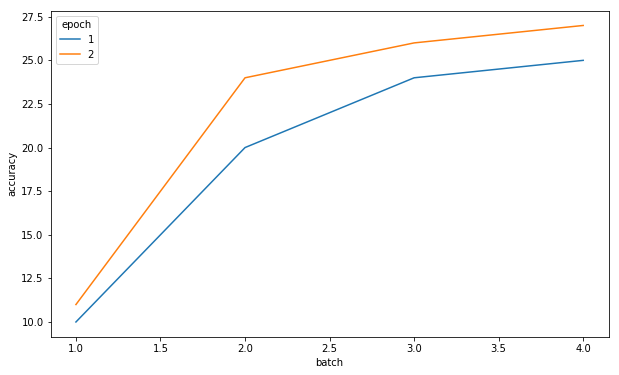

In [142]:
h1 = {'train': { 'accuracy': {1: {1: [10], 2: [20], 3:[24], 4: [25]}, 2: {1: [11], 2: [24], 3:[26], 4: [27]}}}}

df1 = make_df_for_plot(h1)
plot_history_by_epoch_and_batch(df1, 'model accuracy')

In [143]:
def plot_history_by_epoch( df, title, path=None, run_uuid=None):
    '''
    Plot history from training by epoch and batch 
    '''
    fig, ax = pyplot.subplots(figsize=(10,6))
    p_df = df.pivot(index='epoch', columns='batch', values='loss').plot(ax=ax)
             
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.show()
    
    if (path != None and run_uuid!=None):
        pyplot.savefig(path + '/' + str(run_uuid) + '/history_by_epoch_and_batch.png')
        

### LSTM 

Declare class that manages the LSTM - build, train and test

In [43]:
import queue
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import cudnn_rnn
from collections import defaultdict
import data_utils as d
import numpy as np

class LSTM(object):
    
    ''' 
    Character-Level LSTM Implementation Based on Character-Aware Neural Language Models
    Yoon Kim, Yacine Jernite, David Sontag and Alexander Rush 
    https://github.com/yoonkim/lstm-char-cnn
    arXiv:1508.06615v4
    '''
    
    ENCODING = 'utf8'
    
    def __init__(self, experiment_id, device ='/gpu:0', hparams = None):
        
        # Modify hparams (as necessary or use defaults)
        if (hparams==None):
            self.hparams = self.get_hparams()
        else:
            self.hparams = hparams
        
        # Set which device to use (/cpu or /gpu:0/1)
        self.device = device
        max_word_length = self.hparams['max_word_length']
        
        # X is of shape ('b', 'sentence_length', 'max_word_length', 'alphabet_size')
        self.X = tf.placeholder('float32', shape=[None, None, max_word_length, ALPHABET_SIZE], name='X')
        self.Y = tf.placeholder('float32', shape=[None, 2], name='Y')

        # Experiment id (for mlflow)
        self.experiment_id = experiment_id


    def conv2d(self, input_, output_dim, k_h, k_w, name):
        '''
        Conv2d:
        # Modified From https://github.com/mkroutikov/tf-lstm-char-cnn/blob/master/model.py
        '''        
        print(name)

        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim])
            b = tf.get_variable('b', [output_dim])

        return tf.nn.conv2d(input_, w, strides=[1, 1, 1, 1], padding='VALID') + b

    
    def linear(self, input_, output_size, scope=None):
        '''
        Linear map: output[k] = sum_i(Matrix[k, i] * args[i] ) + Bias[k]
        Args:
            args: a tensor or a list of 2D, batch x n, Tensors.
        output_size: int, second dimension of W[i].
        scope: VariableScope for the created subgraph; defaults to "Linear".
        Returns:
            A 2D Tensor with shape [batch x output_size] equal to
            sum_i(args[i] * W[i]), where W[i]s are newly created matrices.
        Raises:
            ValueError: if some of the arguments has unspecified or wrong shape.
        
        # Modified From https://github.com/mkroutikov/tf-lstm-char-cnn/blob/master/model.py
        '''

        shape = input_.get_shape().as_list()
        if len(shape) != 2:
            raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
        if not shape[1]:
            raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
        input_size = shape[1]

        # Now the computation.
        with tf.variable_scope(scope or "SimpleLinear", reuse=tf.AUTO_REUSE):
            matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
            bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

        return tf.matmul(input_, tf.transpose(matrix)) + bias_term

    
    def softmax(self, input_, out_dim, scope=None):
        ''' SoftMax Output '''

        with tf.variable_scope(scope or 'softmax', reuse=tf.AUTO_REUSE):
            W = tf.get_variable('W', [input_.get_shape()[1], out_dim])
            b = tf.get_variable('b', [out_dim])

        return tf.nn.softmax(tf.matmul(input_, W) + b)
                
        
    def build(self):

        kernels = self.hparams['kernels']
        kernel_features = self.hparams['kernel_features']
        rnn_size = self.hparams['rnn_size']
        dropout = self.hparams['dropout']
        self.max_word_length = self.hparams['max_word_length']
        self.train_samples = d.TextReader.get_number_of_samples(TRAIN_SET)
        self.size = np.sum(kernel_features)        
        
        self.hparams["device"]=self.device
        self.hparams["train_samples"]=self.train_samples
        
        BATCH_SIZE = self.hparams['BATCH_SIZE']
        self.BATCH_SIZE = BATCH_SIZE
             
        # Highway & TDNN Implementation are from https://github.com/mkroutikov/tf-lstm-char-cnn/blob/master/model.py
        def highway(input_, size, num_layers, bias, f=tf.nn.relu, scope='Highway'):
            """Highway Network (cf. http://arxiv.org/abs/1505.00387).
            t = sigmoid(Wy + b)
            z = t * g(Wy + b) + (1 - t) * y
            where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
            """

            with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
                for idx in range(num_layers):
                    g = f(self.linear(input_, size, scope='highway_lin_%d' % idx))

                    t = tf.sigmoid(self.linear(input_, size, scope='highway_gate_%d' % idx) + bias)

                    output = t * g + (1. - t) * input_
                    input_ = output

            return output

        def tdnn(input_, kernels, kernel_features, scope='TDNN'):
            ''' Time Delay Neural Network ( cf. http://www.aclweb.org/anthology/P/P14/P14-1062.xhtml )
            :input:           input float tensor of shape [(batch_size*num_unroll_steps) x max_word_length x embed_size]
            :kernels:         array of kernel sizes
            :kernel_features: array of kernel feature sizes (parallel to kernels)
            :
            Time delay neural network (TDNN) is a multilayer artificial neural network architecture whose purpose is to 
            1) classify patterns with shift-invariance
            2) model context at each layer of the network. 
            Shift-invariant classification means that the classifier does not require explicit segmentation prior to classification.
            '''
            assert len(kernels) == len(kernel_features), 'Kernel and Features must have the same size'

            # input_ is a np.array of shape ('b', 'sentence_length', 'max_word_length', 'embed_size') we
            # need to convert it to shape ('b * sentence_length', 1, 'max_word_length', 'embed_size') to
            # use conv2D
            input_ = tf.reshape(input_, [-1, self.max_word_length, ALPHABET_SIZE])
            input_ = tf.expand_dims(input_, 1)

            layers = []
            with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
                for kernel_size, kernel_feature_size in zip(kernels, kernel_features):
                    reduced_length = self.max_word_length - kernel_size + 1

                    # [batch_size * sentence_length x max_word_length x embed_size x kernel_feature_size]
                    conv = self.conv2d(input_, kernel_feature_size, 1, kernel_size, "kernel_%d" % kernel_size)

                    # [batch_size * sentence_length x 1 x 1 x kernel_feature_size]
                    pool = tf.nn.max_pool(tf.tanh(conv), [1, 1, reduced_length, 1], [1, 1, 1, 1], 'VALID')

                    layers.append(tf.squeeze(pool, [1, 2]))

                if len(kernels) > 1:
                    output = tf.concat(layers, 1)
                else:
                    output = layers[0]

            return output

        cnn = tdnn(self.X, kernels, kernel_features)

        # tdnn() returns a tensor of shape [batch_size * sentence_length x kernel_features]
        # highway() returns a tensor of shape [batch_size * sentence_length x size] to use
        # tensorflow dynamic_rnn module we need to reshape it to [batch_size x sentence_length x size]
        cnn = highway(cnn, self.size, num_layers=self.hparams["highway_layers"], bias=self.hparams["highway_bias"])
        cnn = tf.reshape(cnn, [BATCH_SIZE, -1, self.size])

        with tf.variable_scope('LSTM', reuse=tf.AUTO_REUSE):

            # Define LSTM Cell (with dropout)
            def create_rnn_cell():
                cell = rnn.LSTMCell(rnn_size, state_is_tuple=True, forget_bias=0.0, reuse=False, use_peepholes=True)
                if dropout > 0.0:
                    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=1. - dropout)

                return cell

            # Create 1..n LSTM layers
            if (self.hparams["lstm_layers"]==1):
                cell = create_rnn_cell()
            else:
                cells = [create_rnn_cell() for n in range(1,self.hparams["lstm_layers"])]
                cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            
            # Return zero state 
            initial_rnn_state = cell.zero_state(BATCH_SIZE, dtype='float32')

            outputs, final_rnn_state = tf.nn.dynamic_rnn(cell, 
                                                         cnn,
                                                         initial_state=initial_rnn_state,
                                                         dtype=tf.float32)

            # In this implementation, we only care about the last outputs of the RNN
            # i.e. the output at the end of the sentence
            outputs = tf.transpose(outputs, [1, 0, 2])
            last = outputs[-1]

        self.prediction = self.softmax(last, 2)

        
    def train(self):
        
        BATCH_SIZE = self.hparams['BATCH_SIZE']
        EPOCHS = self.hparams['EPOCHS']
        max_word_length = self.hparams['max_word_length']
        learning_rate = self.hparams['learning_rate']
        pred = self.prediction
        history = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))
        
        cost = - tf.reduce_sum(self.Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))
        predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        acc = tf.reduce_mean(tf.cast(predictions, 'float32'))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        n_batch = self.train_samples // BATCH_SIZE

        # parameters for saving and early stopping
        saver = tf.train.Saver()
        patience = self.hparams['patience']
        
        with tf.device(self.device):
            with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
                
                sess.run(tf.global_variables_initializer())
                
                best_acc = 0.0
                DONE = False
                epoch = 0

                # Ensure prior run has been finished
                mlflow.end_run()

                # Start experiment
                with mlflow.start_run(experiment_id = self.experiment_id) as run:
                    
                    # Log hyperparameters to mlflow
                    for k,v in self.hparams.items():
                        mlflow.log_param(k, v)                        
                                                            
                    # Save model path
                    model_path = self.get_path(SAVE_PATH, run.info.run_uuid)        
                    mlflow.log_param('model_path',model_path)
                    
                    print('model path:', model_path)
                    print('model_run:', run.info.run_uuid)
                    
                    while epoch <= EPOCHS and not DONE:
                        loss = 0.0
                        batch = 1
                        epoch += 1

                        print("epoch %d" % epoch)

                        with open(TRAIN_SET, 'r', encoding = LSTM.ENCODING) as f:

                            reader = d.TextReader(f, max_word_length)

                            for minibatch in reader.iterate_minibatch(BATCH_SIZE, dataset=d.TextReader.TRAIN_SET):
                                batch_x, batch_y = minibatch

                                _, c, a = sess.run([optimizer, cost, acc], feed_dict={self.X: batch_x, self.Y: batch_y})

                                loss += c

                                if batch % 100 == 0:
                                    # Compute Accuracy on the Training set and print some info

                                    mlflow.log_metric("epoch",epoch)
                                    mlflow.log_metric("batch",batch) 
                                    mlflow.log_metric("loss",loss/batch)
                                    mlflow.log_metric("accuracy",a)

                                    print("Epoch: %5d/%5d -- batch: %5d/%5d -- Loss: %.4f -- Train Accuracy: %.4f" %
                                          (epoch, EPOCHS, batch, n_batch, loss/batch, a))
                                    
                                # --------------
                                # EARLY STOPPING
                                # --------------

                                # Compute Accuracy on the Validation set, check if validation has improved, save model, etc
                                if batch % 1000 == 0:
                                    accuracy = []

                                    # Review accuracy using QA_SET
                                    with open(QA_SET, 'r', encoding = LSTM.ENCODING) as ff:

                                        valid_reader = d.TextReader(ff, max_word_length)

                                        for mb in valid_reader.iterate_minibatch(BATCH_SIZE, dataset=d.TextReader.QA_SET):
                                            valid_x, valid_y = mb
                                            a = sess.run([acc], feed_dict={self.X: valid_x, self.Y: valid_y})
                                            accuracy.append(a)

                                        mean_acc = np.mean(accuracy)

                                        # Log history (for charts)
                                        history['TEST']['accuracy'][epoch][batch] = a
                                        history['DEV']['accuracy'][epoch][batch] = mean_acc
                                                                                
                                        # if accuracy has improved, save model and boost patience
                                        if mean_acc > best_acc:
                                            best_acc = mean_acc
                                            patience = self.hparams['patience']
                                            mlflow.log_metric("best_acc",best_acc)

                                        # else reduce patience and break loop if necessary
                                        else:                                        
                                            patience -= 500
                                            mlflow.log_metric("patience",patience)
                                            
                                            if patience <= 0:
                                                DONE = True
                                                break

                                        mlflow.log_metric("mean_acc",mean_acc)

                                        print('Epoch: %5d/%5d -- batch: %5d/%5d -- Valid Accuracy: %.4f' %
                                             (epoch, EPOCHS, batch, n_batch, mean_acc))

                                batch += 1
                                   
                        # Save model checkpoint at end of epoch             
                        save_path = saver.save(sess, model_path)
                        print('Model saved in file: %s' % save_path)
        
        return history                                   
                        
        
    def get_path(self, path, run_uuid):
        return path + '/' + str(run_uuid)
    
    
    def evaluate_test_set(self, run_uuid=None):
        '''
        Evaluate Test Set
        '''
        BATCH_SIZE = self.hparams['BATCH_SIZE']
        max_word_length = self.hparams['max_word_length']

        pred = self.prediction
        cost = - tf.reduce_sum(self.Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))
        predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        acc = tf.reduce_mean(tf.cast(predictions, 'float32'))

        # parameters for restoring variables
        saver = tf.train.Saver()
        
        # Ensure prior run has been finished
        mlflow.end_run()
        
        model_path = self.get_path(SAVE_PATH, run_uuid)
        
        # Start experiment
        with mlflow.start_run(experiment_id = self.experiment_id) as run:
            with tf.device(self.device):
                with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

                    print('Loading model %s...' % model_path)
                    saver.restore(sess, model_path)
                    print('Loaded')

                    mlflow.log_param('prior_model',model_path)
                    mlflow.log_param('dataset', DEV_SET)
                    
                    loss = []
                    accuracy = []

                    with open(TEST_SET, 'r', encoding = LSTM.ENCODING) as f:

                        reader = d.TextReader(f, max_word_length)

                        for minibatch in reader.iterate_minibatch(BATCH_SIZE, dataset=d.TextReader.TEST_SET):
                            batch_x, batch_y = minibatch
                            c, a = sess.run([cost, acc], feed_dict={self.X: batch_x, self.Y: batch_y})
                            loss.append(c)
                            accuracy.append(a)

                        loss = np.mean(loss)
                        accuracy = np.mean(accuracy)

                        mlflow.log_metric("loss",loss)
                        mlflow.log_metric("accuracy",accuracy) 

                        print('Valid loss: %.5f -- Valid Accuracy: %.5f' % (loss, accuracy))

                        return loss, accuracy

                    
    def predict_sentences(self, sentences, run_uuid):
        '''
        Analyze Some Sentences

        :sentences: list of sentences
        e.g.: sentences = ['this is veeeryyy bad!!', 'I don\'t think he will be happy abt this',
                            'YOU\'re a fool!', 'I\'m sooo happY!!!']
        '''
        BATCH_SIZE = self.hparams['BATCH_SIZE']
        max_word_length = self.hparams['max_word_length']
        pred = self.prediction

        saver = tf.train.Saver()

        model_path = self.get_path(SAVE_PATH,run_uuid)
        
        with tf.device(self.device):
            with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
                print('Loading model %s...' % model_path)
                saver.restore(sess, model_path)
                print('Loaded')

                # Add placebo value '0,' at the beginning of the sentences to
                # use the make_minibatch() method
                sentences = ['0,' + s for s in sentences]

                with open(TEST_SET, 'r', encoding = LSTM.ENCODING) as f:

                    reader = TextReader(file=f, max_word_length=max_word_length)
                    reader.load_to_ram(BATCH_SIZE)
                    reader.data[:len(sentences)] = sentences
                    batch_x, batch_y = reader.make_minibatch(reader.data)

                    p = sess.run([pred], feed_dict={self.X: batch_x, self.Y: batch_y})

                    for i, s in enumerate(sentences):
                        print('Sentence: %s , yielded results (pos/neg): %.5f/%.5f, prediction: %s' %
                              (s, p[0][i][0], p[0][i][1], 'pos' if max(p[0][i]) == p[0][i][0] else 'neg'))

                return p

    def categorize_sentences(self, sentences, run_uuid):
        """ Op for categorizing multiple sentences (> BATCH_SIZE) """
        # encode sentences
        sentences = [s.encode('utf-8') for s in sentences]

        q = queue.Queue()
        reader = TextReader(file=None, max_word_length=self.max_word_length)
        n_batch = len(sentences) // self.BATCH_SIZE
        pred = self.prediction
        saver = tf.train.Saver()
        results = []

        def fill_list(list, length):
            while len(list) != length:
                list.append('empty sentence.')
            return list

        # Fill queue with minibatches
        for i in range(n_batch + 1):
            if i == n_batch:
                q.put(fill_list(sentences, self.BATCH_SIZE))
            else:
                q.put(sentences[i * self.BATCH_SIZE: (i + 1) * self.BATCH_SIZE])

        model_path = self.get_path(SAVE_PATH,run_uuid)
        
        # Predict
        with tf.device(self.device):
            with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
                print('Loading model %s...' % model_path)
                saver.restore(sess, model_path)
                print('Model loaded')

                while not q.empty():
                    batch = q.get()
                    batch = ['0, ' + s for s in batch]
                    batch_x, batch_y = reader.make_minibatch(batch)
                    p = sess.run([pred], feed_dict={self.X: batch_x, self.Y: batch_y})
                    results.append(p)

        return results
                        
    def get_hparams(self):
        ''' 
        Get Hyperparameters 
        Configured as per research paper
        '''

        return {
            'BATCH_SIZE':       64,
            'EPOCHS':           25,
            'max_word_length':  16, 
            'learning_rate':    0.0001,
            'patience':         10000,
            'highway_layers':   2,
            'highway_bias':     -2.0,
            'lstm_layers':      2,
            'kernels':          [1, 2, 3, 4, 5, 6, 7],
            'kernel_features':  [50, 100, 150, 200, 200, 200, 200],
            'rnn_size':         650,
            'dropout':          0.5
        }

### Build network

Reset tensorflow graph and build char language model with any overridden hyper-parameters

In [144]:
tf.reset_default_graph()
network = LSTM(experiment.experiment_id, hparams = {
            'BATCH_SIZE':       50,
            'EPOCHS':           25,
            'max_word_length':  30, 
            'learning_rate':    0.0001,
            'patience':         10000,
            'highway_layers':   1,
            'highway_bias':     -2.0,
            'lstm_layers':      2,
            'kernels':          [1, 2, 3, 4, 5 ],
            'kernel_features':  [2, 3, 4, 5, 10 ],
            'rnn_size':         1000,
            'dropout':          0.5
        })

# Original config
network.build()

kernel_1
kernel_2
kernel_3
kernel_4
kernel_5


Now lets train the LSTM

In [53]:
h = network.train()

model path: ./checkpoints/lstm/ec5bad5a64fc42f38cc58a3aa696274d
model_run: ec5bad5a64fc42f38cc58a3aa696274d
epoch 1
Epoch:     1/   25 -- batch:   100/20480 -- Loss: 34.7958 -- Train Accuracy: 0.6200
Epoch:     1/   25 -- batch:   200/20480 -- Loss: 34.7538 -- Train Accuracy: 0.4000
Epoch:     1/   25 -- batch:   300/20480 -- Loss: 34.7256 -- Train Accuracy: 0.6200
Epoch:     1/   25 -- batch:   400/20480 -- Loss: 34.7100 -- Train Accuracy: 0.5400
Epoch:     1/   25 -- batch:   500/20480 -- Loss: 34.7062 -- Train Accuracy: 0.5000
Epoch:     1/   25 -- batch:   600/20480 -- Loss: 34.7050 -- Train Accuracy: 0.4600
Epoch:     1/   25 -- batch:   700/20480 -- Loss: 34.6999 -- Train Accuracy: 0.4200
Epoch:     1/   25 -- batch:   800/20480 -- Loss: 34.6906 -- Train Accuracy: 0.5600
Epoch:     1/   25 -- batch:   900/20480 -- Loss: 34.6899 -- Train Accuracy: 0.4800
Epoch:     1/   25 -- batch:  1000/20480 -- Loss: 34.6901 -- Train Accuracy: 0.5200
Epoch:     1/   25 -- batch:  1000/20480 -- 

Epoch:     1/   25 -- batch:  9000/20480 -- Valid Accuracy: 0.6522
Epoch:     1/   25 -- batch:  9100/20480 -- Loss: 32.9117 -- Train Accuracy: 0.6400
Epoch:     1/   25 -- batch:  9200/20480 -- Loss: 32.8739 -- Train Accuracy: 0.6600
Epoch:     1/   25 -- batch:  9300/20480 -- Loss: 32.8405 -- Train Accuracy: 0.5200
Epoch:     1/   25 -- batch:  9400/20480 -- Loss: 32.8045 -- Train Accuracy: 0.6800
Epoch:     1/   25 -- batch:  9500/20480 -- Loss: 32.7683 -- Train Accuracy: 0.7200
Epoch:     1/   25 -- batch:  9600/20480 -- Loss: 32.7323 -- Train Accuracy: 0.7200
Epoch:     1/   25 -- batch:  9700/20480 -- Loss: 32.6968 -- Train Accuracy: 0.5600
Epoch:     1/   25 -- batch:  9800/20480 -- Loss: 32.6641 -- Train Accuracy: 0.6400
Epoch:     1/   25 -- batch:  9900/20480 -- Loss: 32.6296 -- Train Accuracy: 0.7000
Epoch:     1/   25 -- batch: 10000/20480 -- Loss: 32.6002 -- Train Accuracy: 0.7200
Epoch:     1/   25 -- batch: 10000/20480 -- Valid Accuracy: 0.6964
Epoch:     1/   25 -- batc

Epoch:     1/   25 -- batch: 18100/20480 -- Loss: 30.7212 -- Train Accuracy: 0.7400
Epoch:     1/   25 -- batch: 18200/20480 -- Loss: 30.7017 -- Train Accuracy: 0.7600
Epoch:     1/   25 -- batch: 18300/20480 -- Loss: 30.6871 -- Train Accuracy: 0.7400
Epoch:     1/   25 -- batch: 18400/20480 -- Loss: 30.6702 -- Train Accuracy: 0.6400
Epoch:     1/   25 -- batch: 18500/20480 -- Loss: 30.6565 -- Train Accuracy: 0.7200
Epoch:     1/   25 -- batch: 18600/20480 -- Loss: 30.6395 -- Train Accuracy: 0.6400
Epoch:     1/   25 -- batch: 18700/20480 -- Loss: 30.6276 -- Train Accuracy: 0.7000
Epoch:     1/   25 -- batch: 18800/20480 -- Loss: 30.6079 -- Train Accuracy: 0.6600
Epoch:     1/   25 -- batch: 18900/20480 -- Loss: 30.5906 -- Train Accuracy: 0.7400
Epoch:     1/   25 -- batch: 19000/20480 -- Loss: 30.5761 -- Train Accuracy: 0.6800
Epoch:     1/   25 -- batch: 19000/20480 -- Valid Accuracy: 0.7226
Epoch:     1/   25 -- batch: 19100/20480 -- Loss: 30.5573 -- Train Accuracy: 0.6400
Epoch:   

Epoch:     2/   25 -- batch:  6800/20480 -- Loss: 26.8378 -- Train Accuracy: 0.7600
Epoch:     2/   25 -- batch:  6900/20480 -- Loss: 26.8289 -- Train Accuracy: 0.7800
Epoch:     2/   25 -- batch:  7000/20480 -- Loss: 26.8181 -- Train Accuracy: 0.6800
Epoch:     2/   25 -- batch:  7000/20480 -- Valid Accuracy: 0.7348
Epoch:     2/   25 -- batch:  7100/20480 -- Loss: 26.8061 -- Train Accuracy: 0.7400
Epoch:     2/   25 -- batch:  7200/20480 -- Loss: 26.8069 -- Train Accuracy: 0.8800
Epoch:     2/   25 -- batch:  7300/20480 -- Loss: 26.8018 -- Train Accuracy: 0.6400
Epoch:     2/   25 -- batch:  7400/20480 -- Loss: 26.8041 -- Train Accuracy: 0.7400
Epoch:     2/   25 -- batch:  7500/20480 -- Loss: 26.7968 -- Train Accuracy: 0.6800
Epoch:     2/   25 -- batch:  7600/20480 -- Loss: 26.7878 -- Train Accuracy: 0.6400
Epoch:     2/   25 -- batch:  7700/20480 -- Loss: 26.7913 -- Train Accuracy: 0.8000
Epoch:     2/   25 -- batch:  7800/20480 -- Loss: 26.7802 -- Train Accuracy: 0.7800
Epoch:   

Epoch:     2/   25 -- batch: 15900/20480 -- Loss: 26.4807 -- Train Accuracy: 0.8000
Epoch:     2/   25 -- batch: 16000/20480 -- Loss: 26.4792 -- Train Accuracy: 0.8800
Epoch:     2/   25 -- batch: 16000/20480 -- Valid Accuracy: 0.7410
Epoch:     2/   25 -- batch: 16100/20480 -- Loss: 26.4766 -- Train Accuracy: 0.7000
Epoch:     2/   25 -- batch: 16200/20480 -- Loss: 26.4708 -- Train Accuracy: 0.7400
Epoch:     2/   25 -- batch: 16300/20480 -- Loss: 26.4698 -- Train Accuracy: 0.8000
Epoch:     2/   25 -- batch: 16400/20480 -- Loss: 26.4652 -- Train Accuracy: 0.7800
Epoch:     2/   25 -- batch: 16500/20480 -- Loss: 26.4661 -- Train Accuracy: 0.7800
Epoch:     2/   25 -- batch: 16600/20480 -- Loss: 26.4616 -- Train Accuracy: 0.8800
Epoch:     2/   25 -- batch: 16700/20480 -- Loss: 26.4559 -- Train Accuracy: 0.7400
Epoch:     2/   25 -- batch: 16800/20480 -- Loss: 26.4557 -- Train Accuracy: 0.7200
Epoch:     2/   25 -- batch: 16900/20480 -- Loss: 26.4526 -- Train Accuracy: 0.8000
Epoch:   

Epoch:     3/   25 -- batch:  4500/20480 -- Loss: 25.4320 -- Train Accuracy: 0.7600
Epoch:     3/   25 -- batch:  4600/20480 -- Loss: 25.4194 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch:  4700/20480 -- Loss: 25.4210 -- Train Accuracy: 0.6800
Epoch:     3/   25 -- batch:  4800/20480 -- Loss: 25.4214 -- Train Accuracy: 0.7800
Epoch:     3/   25 -- batch:  4900/20480 -- Loss: 25.4181 -- Train Accuracy: 0.8200
Epoch:     3/   25 -- batch:  5000/20480 -- Loss: 25.4134 -- Train Accuracy: 0.6400
Epoch:     3/   25 -- batch:  5000/20480 -- Valid Accuracy: 0.7459
Epoch:     3/   25 -- batch:  5100/20480 -- Loss: 25.4016 -- Train Accuracy: 0.7800
Epoch:     3/   25 -- batch:  5200/20480 -- Loss: 25.4058 -- Train Accuracy: 0.7200
Epoch:     3/   25 -- batch:  5300/20480 -- Loss: 25.3941 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch:  5400/20480 -- Loss: 25.3949 -- Train Accuracy: 0.7600
Epoch:     3/   25 -- batch:  5500/20480 -- Loss: 25.3913 -- Train Accuracy: 0.7600
Epoch:   

Epoch:     3/   25 -- batch: 13600/20480 -- Loss: 25.2516 -- Train Accuracy: 0.8200
Epoch:     3/   25 -- batch: 13700/20480 -- Loss: 25.2475 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch: 13800/20480 -- Loss: 25.2474 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch: 13900/20480 -- Loss: 25.2493 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch: 14000/20480 -- Loss: 25.2478 -- Train Accuracy: 0.7200
Epoch:     3/   25 -- batch: 14000/20480 -- Valid Accuracy: 0.7595
Epoch:     3/   25 -- batch: 14100/20480 -- Loss: 25.2469 -- Train Accuracy: 0.7600
Epoch:     3/   25 -- batch: 14200/20480 -- Loss: 25.2468 -- Train Accuracy: 0.7800
Epoch:     3/   25 -- batch: 14300/20480 -- Loss: 25.2440 -- Train Accuracy: 0.7200
Epoch:     3/   25 -- batch: 14400/20480 -- Loss: 25.2449 -- Train Accuracy: 0.6400
Epoch:     3/   25 -- batch: 14500/20480 -- Loss: 25.2464 -- Train Accuracy: 0.7400
Epoch:     3/   25 -- batch: 14600/20480 -- Loss: 25.2418 -- Train Accuracy: 0.8000
Epoch:   

Epoch:     4/   25 -- batch:  2200/20480 -- Loss: 24.7280 -- Train Accuracy: 0.8200
Epoch:     4/   25 -- batch:  2300/20480 -- Loss: 24.7076 -- Train Accuracy: 0.8600
Epoch:     4/   25 -- batch:  2400/20480 -- Loss: 24.6946 -- Train Accuracy: 0.7200
Epoch:     4/   25 -- batch:  2500/20480 -- Loss: 24.6881 -- Train Accuracy: 0.8000
Epoch:     4/   25 -- batch:  2600/20480 -- Loss: 24.7020 -- Train Accuracy: 0.8200
Epoch:     4/   25 -- batch:  2700/20480 -- Loss: 24.6921 -- Train Accuracy: 0.7000
Epoch:     4/   25 -- batch:  2800/20480 -- Loss: 24.6761 -- Train Accuracy: 0.7600
Epoch:     4/   25 -- batch:  2900/20480 -- Loss: 24.6839 -- Train Accuracy: 0.8800
Epoch:     4/   25 -- batch:  3000/20480 -- Loss: 24.6853 -- Train Accuracy: 0.8200
Epoch:     4/   25 -- batch:  3000/20480 -- Valid Accuracy: 0.7614
Epoch:     4/   25 -- batch:  3100/20480 -- Loss: 24.6703 -- Train Accuracy: 0.8000
Epoch:     4/   25 -- batch:  3200/20480 -- Loss: 24.6723 -- Train Accuracy: 0.7600
Epoch:   

Epoch:     4/   25 -- batch: 11300/20480 -- Loss: 24.6007 -- Train Accuracy: 0.7200
Epoch:     4/   25 -- batch: 11400/20480 -- Loss: 24.5999 -- Train Accuracy: 0.7200
Epoch:     4/   25 -- batch: 11500/20480 -- Loss: 24.5949 -- Train Accuracy: 0.7400
Epoch:     4/   25 -- batch: 11600/20480 -- Loss: 24.5996 -- Train Accuracy: 0.8000
Epoch:     4/   25 -- batch: 11700/20480 -- Loss: 24.5958 -- Train Accuracy: 0.7400
Epoch:     4/   25 -- batch: 11800/20480 -- Loss: 24.5947 -- Train Accuracy: 0.8200
Epoch:     4/   25 -- batch: 11900/20480 -- Loss: 24.5956 -- Train Accuracy: 0.7400
Epoch:     4/   25 -- batch: 12000/20480 -- Loss: 24.5982 -- Train Accuracy: 0.7400
Epoch:     4/   25 -- batch: 12000/20480 -- Valid Accuracy: 0.7637
Epoch:     4/   25 -- batch: 12100/20480 -- Loss: 24.5959 -- Train Accuracy: 0.8000
Epoch:     4/   25 -- batch: 12200/20480 -- Loss: 24.5862 -- Train Accuracy: 0.7200
Epoch:     4/   25 -- batch: 12300/20480 -- Loss: 24.5857 -- Train Accuracy: 0.8200
Epoch:   

Epoch:     4/   25 -- batch: 20400/20480 -- Loss: 24.5238 -- Train Accuracy: 0.8200
Model saved in file: ./checkpoints/lstm/ec5bad5a64fc42f38cc58a3aa696274d
epoch 5
Epoch:     5/   25 -- batch:   100/20480 -- Loss: 24.5592 -- Train Accuracy: 0.7200
Epoch:     5/   25 -- batch:   200/20480 -- Loss: 24.2710 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:   300/20480 -- Loss: 24.3760 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:   400/20480 -- Loss: 24.3627 -- Train Accuracy: 0.8200
Epoch:     5/   25 -- batch:   500/20480 -- Loss: 24.3918 -- Train Accuracy: 0.8000
Epoch:     5/   25 -- batch:   600/20480 -- Loss: 24.3841 -- Train Accuracy: 0.7600
Epoch:     5/   25 -- batch:   700/20480 -- Loss: 24.4139 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:   800/20480 -- Loss: 24.3473 -- Train Accuracy: 0.8200
Epoch:     5/   25 -- batch:   900/20480 -- Loss: 24.3556 -- Train Accuracy: 0.8600
Epoch:     5/   25 -- batch:  1000/20480 -- Loss: 24.3769 -- Train Accuracy: 0.

Epoch:     5/   25 -- batch:  9000/20480 -- Valid Accuracy: 0.7667
Epoch:     5/   25 -- batch:  9100/20480 -- Loss: 24.1505 -- Train Accuracy: 0.6800
Epoch:     5/   25 -- batch:  9200/20480 -- Loss: 24.1523 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:  9300/20480 -- Loss: 24.1515 -- Train Accuracy: 0.7600
Epoch:     5/   25 -- batch:  9400/20480 -- Loss: 24.1517 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:  9500/20480 -- Loss: 24.1477 -- Train Accuracy: 0.8600
Epoch:     5/   25 -- batch:  9600/20480 -- Loss: 24.1519 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch:  9700/20480 -- Loss: 24.1511 -- Train Accuracy: 0.8200
Epoch:     5/   25 -- batch:  9800/20480 -- Loss: 24.1528 -- Train Accuracy: 0.8000
Epoch:     5/   25 -- batch:  9900/20480 -- Loss: 24.1490 -- Train Accuracy: 0.7000
Epoch:     5/   25 -- batch: 10000/20480 -- Loss: 24.1521 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch: 10000/20480 -- Valid Accuracy: 0.7694
Epoch:     5/   25 -- batc

Epoch:     5/   25 -- batch: 18100/20480 -- Loss: 24.1193 -- Train Accuracy: 0.8200
Epoch:     5/   25 -- batch: 18200/20480 -- Loss: 24.1181 -- Train Accuracy: 0.7400
Epoch:     5/   25 -- batch: 18300/20480 -- Loss: 24.1195 -- Train Accuracy: 0.7800
Epoch:     5/   25 -- batch: 18400/20480 -- Loss: 24.1158 -- Train Accuracy: 0.6800
Epoch:     5/   25 -- batch: 18500/20480 -- Loss: 24.1164 -- Train Accuracy: 0.7200
Epoch:     5/   25 -- batch: 18600/20480 -- Loss: 24.1156 -- Train Accuracy: 0.6800
Epoch:     5/   25 -- batch: 18700/20480 -- Loss: 24.1179 -- Train Accuracy: 0.7200
Epoch:     5/   25 -- batch: 18800/20480 -- Loss: 24.1168 -- Train Accuracy: 0.6400
Epoch:     5/   25 -- batch: 18900/20480 -- Loss: 24.1136 -- Train Accuracy: 0.8000
Epoch:     5/   25 -- batch: 19000/20480 -- Loss: 24.1145 -- Train Accuracy: 0.8600
Epoch:     5/   25 -- batch: 19000/20480 -- Valid Accuracy: 0.7697
Epoch:     5/   25 -- batch: 19100/20480 -- Loss: 24.1117 -- Train Accuracy: 0.7400
Epoch:   

Epoch:     6/   25 -- batch:  6800/20480 -- Loss: 23.8226 -- Train Accuracy: 0.6600
Epoch:     6/   25 -- batch:  6900/20480 -- Loss: 23.8144 -- Train Accuracy: 0.8200
Epoch:     6/   25 -- batch:  7000/20480 -- Loss: 23.8084 -- Train Accuracy: 0.7600
Epoch:     6/   25 -- batch:  7000/20480 -- Valid Accuracy: 0.7740
Epoch:     6/   25 -- batch:  7100/20480 -- Loss: 23.8040 -- Train Accuracy: 0.7600
Epoch:     6/   25 -- batch:  7200/20480 -- Loss: 23.8069 -- Train Accuracy: 0.9000
Epoch:     6/   25 -- batch:  7300/20480 -- Loss: 23.8071 -- Train Accuracy: 0.7400
Epoch:     6/   25 -- batch:  7400/20480 -- Loss: 23.8072 -- Train Accuracy: 0.7400
Epoch:     6/   25 -- batch:  7500/20480 -- Loss: 23.8023 -- Train Accuracy: 0.7400
Epoch:     6/   25 -- batch:  7600/20480 -- Loss: 23.7998 -- Train Accuracy: 0.7200
Epoch:     6/   25 -- batch:  7700/20480 -- Loss: 23.8052 -- Train Accuracy: 0.8200
Epoch:     6/   25 -- batch:  7800/20480 -- Loss: 23.7996 -- Train Accuracy: 0.7600
Epoch:   

Results uploaded to MLFlow
http://35.231.123.5:5000/#/metric/loss?runs=[%224fd79258304b43d5b54d9f61ed9d81f3%22]&experiment=2

Evaluate test set on trained LSTM using run_uuid used to store the experiment in mlflow

In [ ]:
network.evaluate_test_set('af2ada32b76f4012bcd35ae436bb03ef')

### Plot accuracy vs batch and epoch

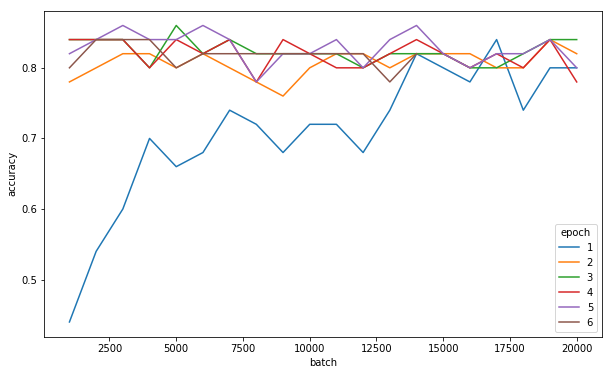

In [145]:
p_df = make_df_for_plot(h, 'TEST','accuracy')
plot_history_by_epoch_and_batch(p_df, 'model accuracy')